# <font color=cyan> Payment use case: this program demonstrates how you can <br> manage transfers in Kyriba using APIs </font>


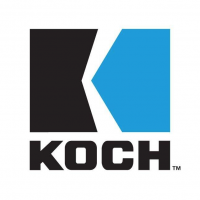

## <font color='yellow'>Code for token generation and API management</font>
      

In [ ]:
#@title Import modules
import requests, base64
import re
import json
import pandas as pd
import time
from io import StringIO
from datetime import datetime,date

In [ ]:
#@title Token generation
#@markdown This code calls the token end point with client-id and secret

def login():
    cfg = pd.read_csv("/content/config.csv")
    client_id = cfg['client_id'].values[0]
    client_secret = cfg['client_secret'].values[0]
    token_endpoint = cfg['token_url'].values[0]
    
    data = {'grant_type': 'client_credentials'}
    
    userpass = client_id + ':' + client_secret
    encoded_u = base64.b64encode(userpass.encode()).decode()
    auth_header = "Basic " + encoded_u
    headers = {
        'Content-Type': 'application/x-www-form-urlencoded',
        'Authorization': auth_header
    }

    r = requests.post(token_endpoint, headers=headers, data=data)
    response = r.json()

    if (r.status_code == 200):
        token = response['access_token']
        # Put token in the session
        print(token)
    return token

In [ ]:
#@title Get Results 
#@markdown This code calls the end point to retrieve data
def get_results(token, request):
    try:
        headers = {"Authorization": "Bearer " + token}
        cfg = pd.read_csv("config.csv")
        base_url = cfg['base_url'].values[0]
        result = requests.get(base_url + request, headers=headers)
        if 200 <= result.status_code < 300:
          return result.text
        else:
          print(result.text)
          return  
    except:
        return

In [ ]:
#@title Post results  
#@markdown This code allows to POST data in payload or as a stream
def post_results(token, request, payload, files):
    try:
        headers = {"Authorization": "Bearer " + token}
        cfg = pd.read_csv("config.csv")
        base_url = cfg['base_url'].values[0]
        result = requests.post(base_url + request, headers=headers, data=payload, files = files)
        if 200 <= result.status_code < 300:
          json_data = json.loads(result.text)
          return json_data
        else:
          print(result.text)
          return
    except:
        return

In [ ]:
#@title Launch report
#@markdown Code to manage report launch and retrieval of data in one function
#@markdown It launchs the task and waits until completion
def run_report(token, report):
    try:
        result = post_results(token, '/v1/process-templates/'+ report +'/run',"","")
        #pprint (result,indent=1)
        taskId = result[0]['taskId']
        while True:
            result = get_results(token, '/v1/process-templates/'+ taskId +'/status')
            if result == "Pending" or result == "In progress":
                print ('.', end='')
            else:
                print ('\n' + result)
            if result == "Warning" or result == "Complete" or result == "Error":
                break
                time.sleep(1)
        print('\n')
        result = get_results(token, '/v1/process-templates/'+ report + '/files?taskId=' + taskId )
        #print(result)
        return result
    except:
        return

In [ ]:
#@title Launch process
#@markdown Code to manage process launch
#@markdown It launchs the task and waits until completion
def run_process(token, report):
    try:
        result = post_results(token, '/v1/process-templates/'+ report +'/run',"","")
        #pprint (result,indent=1)
        taskId = result[0]['taskId']
        while True:
            result = get_results(token, '/v1/process-templates/'+ taskId +'/status')
            if result == "Pending" or result == "In progress":
                print ('.', end='')
            else:
                print ('\n' + result)
            if result == "Warning" or result == "Complete" or result == "Error":
                break
                time.sleep(1)
        return result
    except:
        return

In [ ]:
#@title Pretty print
#@markdown Code to pretty print a json
def pp_json(json_thing, sort=False, indents=2):
    if type(json_thing) is str:
        print(json.dumps(json.loads(json_thing), sort_keys=sort, indent=indents))
    else:
        print(json.dumps(json_thing, sort_keys=sort, indent=indents))
    return None

In [ ]:
#@title Import Data
#@markdown Code to Import Data in one function
#@markdown It uploads data, launchs the task and waits until completion
def import_data (token, data, filename, task, traceflag):
  try:
      payload={}
      files=[
        ('file0', (filename, data, 'text/plain'))
      ]

      result = post_results(token, '/v1/data/files', payload, files)
      if traceflag:
          print (result)
      uuid = result[0]['uuid']

    # run task with file
      result = post_results(token, '/v1/process-templates/' + task + '/run?fileIds=' + uuid, "","")
      if traceflag:
        print (result)
      taskId = result[0]['taskId']

    # wait until process complete
      while True:
          result = get_results(token, '/v1/process-templates/' + taskId + '/status')
          if result == "Pending" or result == "In progress":
              print ('.', end='')
          else:
              print ('\n' + result)
          if result == "Warning" or result == "Complete" or result == "Error":
              break
          time.sleep(1)
      if traceflag:
        logs = get_results(token, '/v1/tasks/' + taskId + '/details')
        print ('\ntask details')
        print (pp_json(logs))

      return result
  except:
    return 'error'

## <font color='yellow'>Connect and  retrieve token</font>

In [ ]:
#@title <font color='lime'>Connect</font>
print('token:')
token = login()

token:
06df9e67-932f-40b9-8f47-f879ed9da754


## <font color='yellow'>Import transfers: SUCCESS and FAILURE cases</font>

In [ ]:
#@title <font color='lime'>Launch report on integrated transfers</font>
res = run_report(token,'PY_EXP')
buffer = StringIO(res)
df1 = pd.read_csv (buffer,delimiter=';',usecols=[0,3,5,6,7,8,9,10],names=['transaction number', 'status','payor','debit account','transaction date','amount','third-party','reference'],header=None)
df1

..
Complete




,transaction number,status,payor,debit account,transaction date,amount,third-party,reference
0,COMDOML000476,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000.0,THIRDPARTY-DEMO,demo successes_1
1,COMDOML000477,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000.0,THIRDPARTY-DEMO,demo successes_1
2,COMDOML000478,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000.0,THIRDPARTY-DEMO,demo successes_1
3,COMDOML000482,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000.0,THIRDPARTY-DEMO,demo successes_1
4,COMDOML000480,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000.0,THIRDPARTY-DEMO,demo successes_1
...,...,...,...,...,...,...,...,...
63,COMDOML000532,RG,COMPANY-DEMO,C05-DEMO-EUR,21072021,1042.0,THIRDPARTY-DEMO,demo successes_9
64,COMDOML000530,RG,COMPANY-DEMO,C05-DEMO-EUR,21072021,1042.0,THIRDPARTY-DEMO,demo successes_7
65,COMDOML000531,RG,COMPANY-DEMO,C05-DEMO-EUR,21072021,1042.0,THIRDPARTY-DEMO,demo successes_8
66,COMDOML000529,RG,COMPANY-DEMO,C05-DEMO-EUR,21072021,1042.0,THIRDPARTY-DEMO,demo successes_6


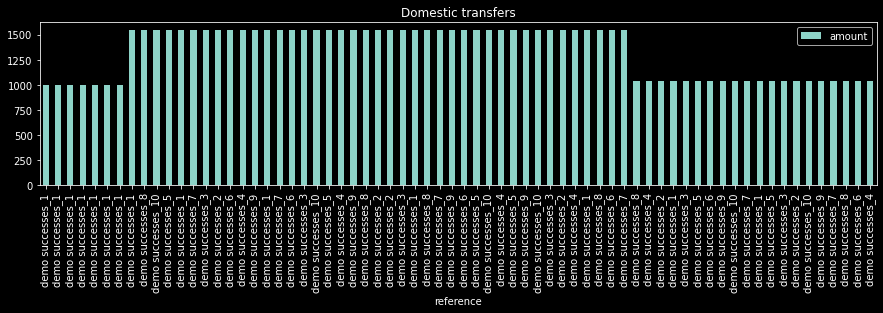

In [ ]:
#@title <font color='lime'>Visualize integrated transfers</font>
from matplotlib import style
style.use('dark_background')
try:
  df1.plot.bar( x= 'reference', y ='amount', title="Domestic transfers", figsize=(15,3));
except Exception as e: 
  print(e)

In [ ]:
#@title <font color='lime'>Enter transaction date, amount and PET</font>
transactionDate = "2021-07-13" #@param {type:"date"}
amount =   1545#@param {type:"number"}
PET =  "LC1" #@param ["LC1"]  {allow-input: true}
#@markdown ---
#@markdown ### successes:
manageSuccesses = False #@param {type:"boolean"}
successReference = "demo successes" #@param ["demo API"] {allow-input: true}
paymentMultiplier = 10  #@param {type:"slider", min:1, max:100, step:1}
#@markdown ---
#@markdown ### failures:
manageFailures = False #@param {type:"boolean"}
errorReference = "demo failures" #@param ["demo API error"] {allow-input: true}
errorMultiplier = 1  #@param {type:"slider", min:1, max:100, step:1}
#@markdown ---
traces = True #@param {type:"boolean"}

if manageSuccesses is True or manageFailures is True:
  stop = False
else:
  stop = True

data = ""

transformedDate =   transactionDate[8:10] + transactionDate[5:7] + transactionDate[0:4] 

if manageSuccesses:
  for i in range(1, paymentMultiplier + 1):
    data_in = ";" + transformedDate + ";" + str(amount) + ";;" + PET + ";" + successReference + "_" + str(i) + "\r\n"
    data = data + data_in

if manageFailures:
  for i in range(1, errorMultiplier + 1):
    data_out = ";" + transformedDate + ";" + str(amount) + ";;error;" + errorReference + "_" + str(i) + "_error\r\n"
    data = data + data_out
  
today = date.today()
now = datetime.now()
dt_string = str(today) + 'T' + now.strftime("%H:%M")
filename = dt_string + "-" + str(paymentMultiplier) + "-" + successReference + "-" + str(errorMultiplier) + "-" + errorReference + "-" + PET + ".csv"

if traces:
  print('data:\r\n' + data)
  print('\r\nsuccessReference:' + successReference)
  print('\r\nerrorReference:' + errorReference)

if not stop:
  print('\r\nstored data on KApp:' + filename)
  res = import_data(token, data, filename,'DEMO_PY_AP', traces)
else:
  print("At least a payment should be added!")


data:
;13072021;1545;;LC1;demo successes_1
;13072021;1545;;LC1;demo successes_2
;13072021;1545;;LC1;demo successes_3
;13072021;1545;;LC1;demo successes_4
;13072021;1545;;LC1;demo successes_5
;13072021;1545;;LC1;demo successes_6
;13072021;1545;;LC1;demo successes_7
;13072021;1545;;LC1;demo successes_8
;13072021;1545;;LC1;demo successes_9
;13072021;1545;;LC1;demo successes_10
;13072021;1545;;error;demo failures_1_error


successReference:demo successes

errorReference:demo failures

stored data on KApp:2021-07-14T08:54-10-demo successes-1-demo failures-LC1.csv
[{'uuid': '1b2e9d8a-aae5-473b-8a1a-68f154b17e8b', 'filename': '2021-07-14T08:54-10-demo successes-1-demo failures-LC1.csv', 'hashSum': 'AC9FA6D5476E975A953534414F16F58F'}]
[{'fileId': '1b2e9d8a-aae5-473b-8a1a-68f154b17e8b', 'taskId': 'f73640ce-4140-4658-97a9-a502f176250a'}]
.
Warning

task details
{
  "uuid": "f73640ce-4140-4658-97a9-a502f176250a",
  "taskType": "Integration of uploaded files",
  "taskDescription": "Automatic",
  "

In [246]:
#@title <font color='lime'>Launch report on rejections</font>
res = run_report(token,'PY_REJ')
buffer = StringIO(res[3:])
#df2 = pd.read_csv (buffer)
#i = iter(range(1, len(df2.columns) + 1))
#df2.columns = [x if not x.startswith('Unnamed') else next(i) for x in df2.columns]
df2 = pd.read_csv (buffer,skiprows=[0,1,2],names=['file name', 'file upload date', 'process template', 'account', 'amount', 'transaction date', 'reference', 'PET', 'error code', 'error field', 'error description', 'original value'], header=None)
display(df2)


Complete




,file name,file upload date,process template,account,amount,transaction date,reference,PET,error code,error field,error description,original value
0,2021-07-14T07:20-1-demo successes-1-demo failu...,07/14/2021,DEMO_PY_AP,NaN,1 000.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
1,2021-07-14T07:22-1-demo successes-1-demo failu...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
2,2021-07-14T07:24-1-demo successes-2-demo failu...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_2_error,error,3,PET,The field value does not exist in the set-up,error
3,2021-07-14T07:24-1-demo successes-2-demo failu...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
4,2021-07-14T08:36-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
5,2021-07-14T08:43-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
6,2021-07-14T08:54-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
7,2021-07-14T10:58-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
8,2021-07-14T11:09-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 042.00,07/21/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
9,2021-07-14T11:11-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 042.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error


In [247]:
#@title <font color='lime'>Retrieve which references were imported</font>
# df2.loc[df2['reference'].str.startswith(successReference) | df2['reference'].str.startswith(errorReference)]
pd.concat([df1, df2])

,transaction number,status,payor,debit account,transaction date,amount,third-party,reference,file name,file upload date,process template,account,PET,error code,error field,error description,original value
0,COMDOML000476,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000,THIRDPARTY-DEMO,demo successes_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,COMDOML000477,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000,THIRDPARTY-DEMO,demo successes_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,COMDOML000478,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000,THIRDPARTY-DEMO,demo successes_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,COMDOML000482,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000,THIRDPARTY-DEMO,demo successes_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,COMDOML000480,RG,COMPANY-DEMO,C05-DEMO-EUR,12072021,1000,THIRDPARTY-DEMO,demo successes_1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16,NaN,NaN,NaN,NaN,07/13/2021,1 042.00,NaN,demo successes_1,2021-07-14T11:22-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,LC,3.0,PET,The field value does not exist in the set-up,LC
17,NaN,NaN,NaN,NaN,07/13/2021,1 042.00,NaN,demo successes_5,2021-07-14T11:22-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,LC,3.0,PET,The field value does not exist in the set-up,LC
18,NaN,NaN,NaN,NaN,07/13/2021,1 042.00,NaN,demo failures_1_error,2021-07-14T11:22-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,error,3.0,PET,The field value does not exist in the set-up,error
19,NaN,NaN,NaN,NaN,07/13/2021,1 042.00,NaN,demo successes_2,2021-07-14T11:22-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,LC,3.0,PET,The field value does not exist in the set-up,LC


In [ ]:
#@title <font color='lime'>Retrieve the rejection reason</font>
filenameRej = filename + '_rej'
df2.loc[df2[0] == filenameRej]

,0,1,2,3,4,5,6,7,8,9,10,11
7,2021-07-14T08:54-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error


In [ ]:
#@title <font color='lime'>Retrieve the rejected references</font>
df2.loc[df2[6].str.startswith(successReference) | df2[6].str.startswith(errorReference)]

,0,1,2,3,4,5,6,7,8,9,10,11
1,2021-07-14T07:20-1-demo successes-1-demo failu...,07/14/2021,DEMO_PY_AP,NaN,1 000.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
2,2021-07-14T07:22-1-demo successes-1-demo failu...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
3,2021-07-14T07:24-1-demo successes-2-demo failu...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_2_error,error,3,PET,The field value does not exist in the set-up,error
4,2021-07-14T07:24-1-demo successes-2-demo failu...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
5,2021-07-14T08:36-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
6,2021-07-14T08:43-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error
7,2021-07-14T08:54-10-demo successes-1-demo fail...,07/14/2021,DEMO_PY_AP,NaN,1 545.00,07/13/2021,demo failures_1_error,error,3,PET,The field value does not exist in the set-up,error


## <font color='yellow'>Kyriba APIs: build your future</font>

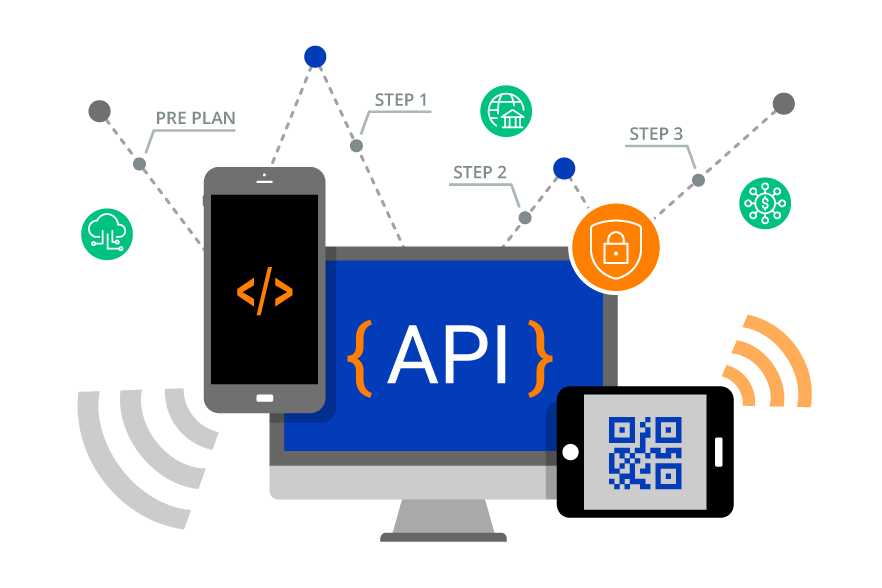